<a href="https://colab.research.google.com/github/my-tech123/assignment-3/blob/main/assignement_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

✅ Dataset Loaded Successfully!
Shape: (200, 5)
   CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
3           4  Female   23                  16                      77
4           5  Female   31                  17                      40

Selected Features for Clustering:
 ['CustomerID', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)']


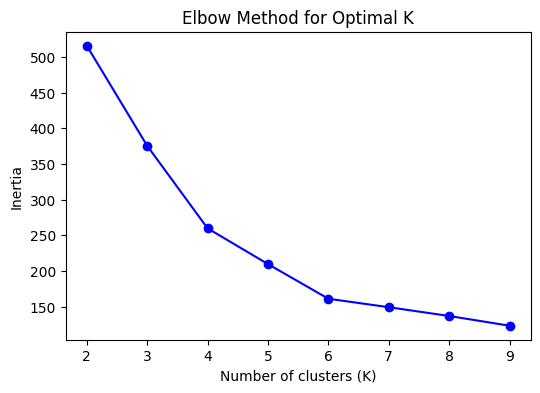


✅ K-Means Silhouette Score: 0.427


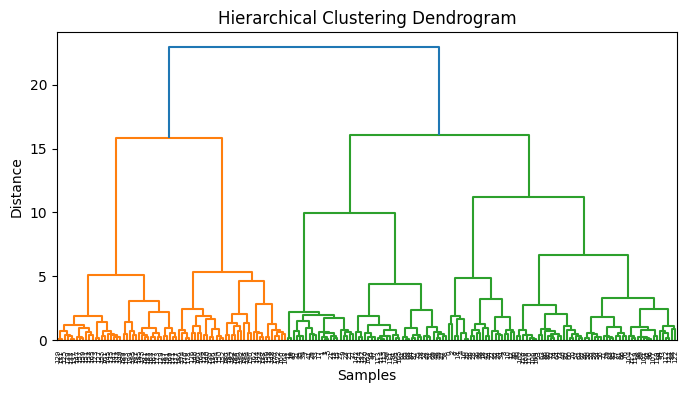

✅ Hierarchical Clustering Silhouette Score: 0.418

🔍 DBSCAN Parameter Tuning...


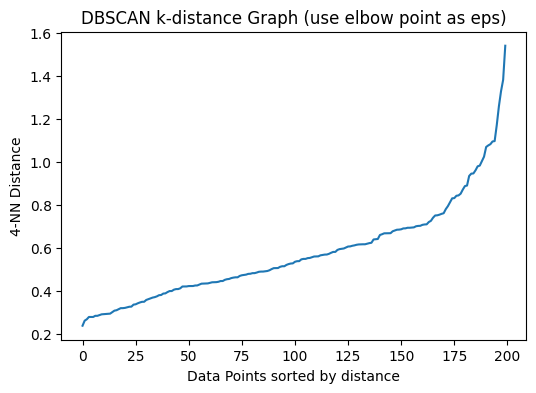

✅ DBSCAN worked with eps=0.3, clusters=5, Silhouette=0.699


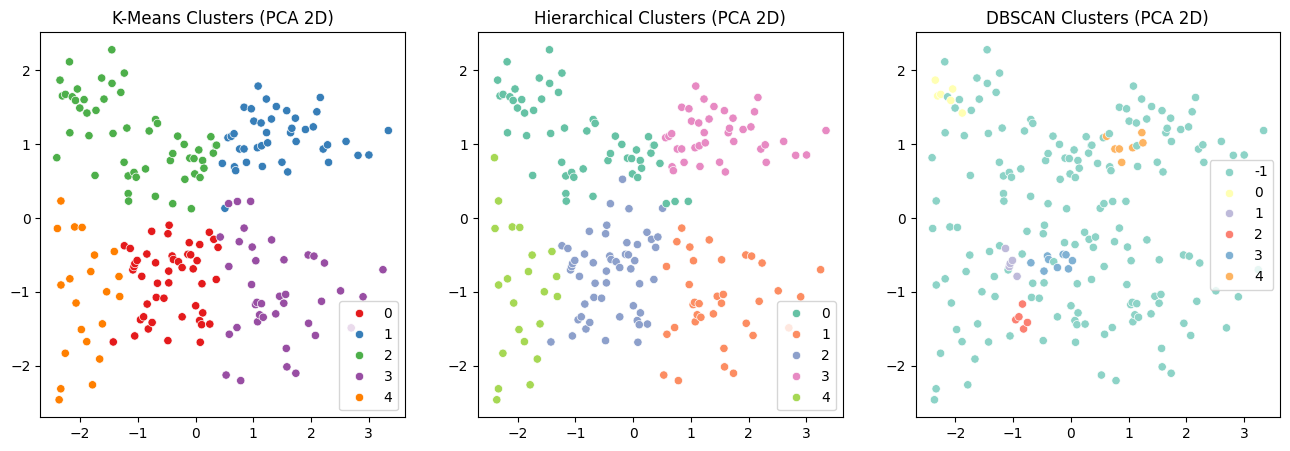


📊 Clustering Performance Summary:
      Algorithm  Silhouette Score  No. of Clusters
0       K-Means          0.427240                5
1  Hierarchical          0.417867                5
2        DBSCAN          0.699301                6


In [4]:
# ===============================================================
# CUSTOMER SEGMENTATION USING K-MEANS, HIERARCHICAL & DBSCAN
# ===============================================================

# --- Install dependencies (if needed) ---
# !pip install pandas numpy matplotlib seaborn scikit-learn scipy

# --- Import Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.neighbors import NearestNeighbors

# --- Load Dataset ---
path = "Mall_Customers.csv"   # Your uploaded CSV
df = pd.read_csv(path)

print("✅ Dataset Loaded Successfully!")
print("Shape:", df.shape)
print(df.head())

# --- Select Numeric Columns ---
X = df.select_dtypes(include=['float64', 'int64'])
print("\nSelected Features for Clustering:\n", X.columns.tolist())

# --- Handle Missing Values ---
X = X.dropna()

# --- Standardize Data ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ===============================================================
# 1️⃣ K-MEANS CLUSTERING + ELBOW METHOD
# ===============================================================
inertia = []
K = range(2, 10)

for k in K:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_scaled)
    inertia.append(km.inertia_)

plt.figure(figsize=(6,4))
plt.plot(K, inertia, 'bo-')
plt.title("Elbow Method for Optimal K")
plt.xlabel("Number of clusters (K)")
plt.ylabel("Inertia")
plt.show()

# Choose K=5 as example (you can adjust based on elbow plot)
kmeans = KMeans(n_clusters=5, random_state=42)
labels_kmeans = kmeans.fit_predict(X_scaled)
sil_kmeans = silhouette_score(X_scaled, labels_kmeans)
print(f"\n✅ K-Means Silhouette Score: {sil_kmeans:.3f}")

# ===============================================================
# 2️⃣ HIERARCHICAL CLUSTERING
# ===============================================================
plt.figure(figsize=(8,4))
link = linkage(X_scaled, method='ward')
dendrogram(link)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Samples")
plt.ylabel("Distance")
plt.show()

hc = AgglomerativeClustering(n_clusters=5)
labels_hc = hc.fit_predict(X_scaled)
sil_hc = silhouette_score(X_scaled, labels_hc)
print(f"✅ Hierarchical Clustering Silhouette Score: {sil_hc:.3f}")

# ===============================================================
# 3️⃣ DBSCAN CLUSTERING (auto parameter tuning)
# ===============================================================
print("\n🔍 DBSCAN Parameter Tuning...")
neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(X_scaled)
distances, indices = neighbors_fit.kneighbors(X_scaled)
distances = np.sort(distances[:, 4], axis=0)

plt.figure(figsize=(6,4))
plt.plot(distances)
plt.title("DBSCAN k-distance Graph (use elbow point as eps)")
plt.xlabel("Data Points sorted by distance")
plt.ylabel("4-NN Distance")
plt.show()

sil_db = np.nan
labels_db = None

for eps_val in [0.3, 0.5, 0.8, 1.0, 1.5]:
    dbscan = DBSCAN(eps=eps_val, min_samples=5)
    labels_db = dbscan.fit_predict(X_scaled)
    n_clusters = len(set(labels_db)) - (1 if -1 in labels_db else 0)

    if n_clusters >= 2:
        sil_db = silhouette_score(X_scaled[labels_db != -1], labels_db[labels_db != -1])
        print(f"✅ DBSCAN worked with eps={eps_val}, clusters={n_clusters}, Silhouette={sil_db:.3f}")
        break
else:
    print("⚠️ DBSCAN could not form valid clusters (only noise or single cluster).")

# ===============================================================
# 4️⃣ PCA VISUALIZATION
# ===============================================================
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

fig, axes = plt.subplots(1, 3, figsize=(16,5))

sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=labels_kmeans, palette='Set1', ax=axes[0])
axes[0].set_title('K-Means Clusters (PCA 2D)')

sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=labels_hc, palette='Set2', ax=axes[1])
axes[1].set_title('Hierarchical Clusters (PCA 2D)')

if labels_db is not None:
    sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=labels_db, palette='Set3', ax=axes[2])
    axes[2].set_title('DBSCAN Clusters (PCA 2D)')
else:
    axes[2].set_title('DBSCAN: No valid clusters')

plt.show()

# ===============================================================
# 5️⃣ COMPARISON SUMMARY
# ===============================================================
summary_data = {
    'Algorithm': ['K-Means', 'Hierarchical', 'DBSCAN'],
    'Silhouette Score': [sil_kmeans, sil_hc, sil_db],
    'No. of Clusters': [
        len(np.unique(labels_kmeans)),
        len(np.unique(labels_hc)),
        len(np.unique(labels_db)) if labels_db is not None else np.nan
    ]
}

summary = pd.DataFrame(summary_data)
print("\n📊 Clustering Performance Summary:")
print(summary)
